# Applied Data Science Capstone

## Table of Contents

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)


## Introduction

### Business Problem

In this study I consider myself to be the owner of an existing, successful, brick-and-mortar coffee shop near Arizona State University in Tempe, AZ and seek to find a neighborhood into which I can expand in the Denver, CO metropolitan area.

Combining demographic with location data from a Location-Based Social Network (LBSN) I will attempt to use K-Means Clustering to find similar locations in the Denver metropolitan area that I'm hoping will allow me to limit my search areas and focus instead on more specific location and available real-estate.

Knowing my current customers, ideally, my expansion would be in an area in or near one of Denver's older but growing neighborhoods, possibly in or near one of the [Top Neighborhoods for Young Professionals](http://urbanphenix.com/neighborhoods-in-denver-for-young-professionals/), not in close proximity to an international airport (which is something I don't like about my current location), have less than 50% of existing coffee shops be independent, and possibly near some or all of the following 'anchor' venues:

* A university and/or medical complex
* An arts district and/or performing arts complex
* Professional office buildings


### Target Audience

While this study is limited in scope, namely the expansion of a single business, and may not have broad appeal, it does provide a working example and demonstrates the power of data in providing actionable intelligence to a business. If I were the business owner, it would help me to narrow my search to specific areas of Denver that might feel familiar and in which I could find similar customers, and help me to focus my efforts on other aspects of expansion, such as staffing, real-estate, and a modified business plan.

## Data

In order to solve the stated problem I am going to be combining data from multiple sources.

* A list of target zip codes in the Denver metropolitan area and for Tempe, AZ
* Demographic information for all the zip codes
* Categorical, venue and attraction data from an LBSN
* A comprehensive list of franchise coffee shops

The following data sources will be used to collect the necessary data

* Zip-Codes.com for the list of zip codes in and around Denver
* HomeTownLocator.com for the demographics of the various zip codes and for Tempe, AZ
* Google Geolocation API for locating the centroids of the zip codes
* Foursquare API for the recommended venue data and category data
* Wikipedia for a list of franchise coffee shops

### Data Acquisition

The bulk of the code responsible for obtaining the data exists in my [**Python Utility Module**](https://github.com/jrfoster/Coursera_Capstone/blob/master/capstoneutils.py), which is also linked at the bottom of the study, in the [References](#References). First, we will import that, and the other libraries necessary for the remainder of the work.

In [1]:
import capstoneutils as csutil
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn plot style
sns.set_style("whitegrid")

#### Zip Codes and Demographics

The following will use my module to retrieve the zip code and demographics data, either from a file or by building it from scratch using the noted sources. Because of the growth in Denver and the associated inflation in the cost of real estate and therefore salaries, note that I am making an adjustment two two demographic features for Tempe. Specifically, I'm adjusting the median home value by a factor of 1.53 and the average household income by a factor of 1.21. This is based on information from [Sperling's Best Places](https://www.bestplaces.net/cost-of-living/tempe-az/denver-co/50000). These adjustments allow for a like-for-like comparison on the two features.

The demographics site provides 19 features per zip code which are divided into four categories: Population, Housing, Income and Households. The following table summarizes the features in each category.

| Section | Notes |
| :--------- | :---|
| Population | Total population, population in families, households, density and diversity index |
| Housing | Total Housing Units (owner- and renter-occupied, vacant) and average  home values |
| Income | Median and mean household income and per capita income |
| Households | Total households, average household size, family households and average family size |

Note that there are six zip codes in the Denver metro area for which HometownLocator has no demographic information, and two that has demographics but the values are all zeros. When manually inspecting the pages for these zip codes, the site suggests to use `80202` as a substitute. In scraping demographics, I do fall back to that zip which creates duplicates in results, which I then remove. This means that there are seven eight codes that are being removed from the list obtained via Zip-Codes.com.



In [2]:
results = csutil.load_demographics()
results.loc[results.ZipCode == '85281', 'Median Home Value'] = int(results.loc[results.ZipCode == '85281', 'Median Home Value'] * 1.53)
results.loc[results.ZipCode == '85281', 'Average Household Income'] = int(results.loc[results.ZipCode == '85281', 'Average Household Income'] * 1.21)
results.tail()

Geocoding: Using pickled demographics/geocoding.


,ZipCode,Latitude,Longitude,Average Family Size,Average Home Value,Average Household Income,Average Household Size,Diversity Index3,Family Households,Median Home Value,...,Per Capita Income,Population Density2,Population in Familes,Population in Group Qrtrs,Population in Households,Renter Occupied HU,Total Households,Total Housing Units,Total Population,Vacant Housing Units
90,80302,40.038629,-105.371668,3,779382,87478,2.17,28,3994,673618,...,39288,292,10922,1808,28051,7938,12930,13629,29859,699
91,80303,40.000538,-105.207780,3,630501,88061,2.03,37,4623,558063,...,41215,738,13080,2069,25253,7207,12447,12967,27322,520
92,80304,40.045474,-105.283851,3,714307,128222,2.34,38,6427,651186,...,54584,3573,19271,375,27701,3624,11844,12359,28076,515
93,80305,39.979999,-105.248737,3,608794,122365,2.42,27,3791,528506,...,50622,2462,10864,34,17533,2549,7257,7396,17567,139
94,85281,33.436665,-111.940325,3,224072,57902,2.15,74,8653,302061,...,20533,5453,26833,11392,58682,21935,27351,31443,70074,4092


#### Foursquare Venues

Below, up to 100 recommended venues are returned for each of the geolocated zip codes. 

In [3]:
result_venues = csutil.load_foursquare_venues(names = results['ZipCode'],lats = results['Latitude'],lngs=results['Longitude'])
result_venues.head()

Using pickled venue data.


,ZipCode,Centroid Latitude,Centroid Longitude,Venue,Venue Latitude,Venue Longitude,Venue Main Category,Venue Top-Level Category
0,80202,39.754103,-105.000224,Denver Union Station,39.753264,-105.000213,Train Station,Travel & Transport
1,80202,39.754103,-105.000224,Whole Foods Market,39.754436,-105.001675,Grocery Store,Shop & Service
2,80202,39.754103,-105.000224,TAVERNETTA,39.753099,-105.001754,Italian Restaurant,Food
3,80202,39.754103,-105.000224,Wynkoop Brewing Co.,39.753580,-104.998396,Brewery,Nightlife Spot
4,80202,39.754103,-105.000224,Hopdoddy Burger Bar Denver,39.753551,-104.999239,Burger Joint,Food


The method used in the course labs for clustering based on the top venues and their categories generated a lot of features. Clustering high-dimensional data comes with its own sets of problems and usually requires different techniques than K-Means. In my case, this is true because the concept of 'distance' between points is based on the means of a lot of zeros and ones, which over a large number of features, becomes almost meaningless. In my own clustering work for this class, based on silhouette analysis, I discovered repeatedly that the best number of clusters was 2.

Because of this, I'm using what is called [Simpson's Diversity Index](http://www.countrysideinfo.co.uk/simpsons.htm) which is normally meant for measuring biodiversity, but it does allow us to measure the *richness* and *evenness* of populations. It is easily adaptable to venues and their categories. In my approach, I'm collecting the tree of [Foursquare Categories](https://developer.foursquare.com/docs/resources/categories) and using the top-level categories as a sort of 'species'. This approach allows me to preserve the information in the types and numbers of venues and significantly reduce the dimensions in the dataset.

The code below calculates these metrics and adds them to our venue results.  The result gives us just 28 features.

In [4]:
# Calculate our version of Simpson's Diversity Index. Note that we are using
# the Reciprocal Index.
t1 = result_venues.loc[:, ['ZipCode', 'Venue Top-Level Category', 'Venue Main Category', 'Venue']]
t2 = t1.groupby(by=['ZipCode', 'Venue Top-Level Category', 'Venue Main Category'])['Venue'].count().reset_index()
t2.rename(columns={'Venue': 'Little-n'}, inplace=True)
t3 = t2.groupby(by=['ZipCode', 'Venue Top-Level Category'])['Little-n'].sum().reset_index()
t3.rename(columns={'Little-n': 'Big-N'}, inplace=True)
t4 = pd.merge(t2,t3,left_on=['ZipCode','Venue Top-Level Category'], right_on=['ZipCode','Venue Top-Level Category'], how='inner', validate='m:1')
t4['Squared n-N Ratio'] = t4.apply(lambda row: pd.Series((row['Little-n'] / row['Big-N'])**2), axis=1)
t5 = t4.groupby(by=['ZipCode', 'Venue Top-Level Category'])['Squared n-N Ratio'].sum().reset_index()
t5['Simpsons RI'] = t5.apply(lambda row: pd.Series(1 / row['Squared n-N Ratio']), axis=1)
t5.drop('Squared n-N Ratio', axis=1, inplace=True)
t6 = pd.pivot_table(t5, index='ZipCode', columns='Venue Top-Level Category', values='Simpsons RI', fill_value=0.0)

# Merge our diversity indexes with the demographics for the final merged dataset
# We should end up with a shape of (87,31)
final_merged = pd.merge(results, t6, how='inner', left_on='ZipCode', right_on='ZipCode', indicator=False, validate='one_to_one')
final_merged.tail()

,ZipCode,Latitude,Longitude,Average Family Size,Average Home Value,Average Household Income,Average Household Size,Diversity Index3,Family Households,Median Home Value,...,Vacant Housing Units,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
80,80302,40.038629,-105.371668,3,779382,87478,2.17,28,3994,673618,...,699,2.0,0,22.084507,5.400000,4.200000,0,0,7.142857,1.000000
81,80303,40.000538,-105.207780,3,630501,88061,2.03,37,4623,558063,...,520,3.0,0,14.440000,2.117647,7.714286,2,0,15.206897,2.000000
82,80304,40.045474,-105.283851,3,714307,128222,2.34,38,6427,651186,...,515,5.0,0,21.591837,2.571429,5.062500,0,0,11.636364,1.000000
83,80305,39.979999,-105.248737,3,608794,122365,2.42,27,3791,528506,...,139,3.0,4,12.000000,4.000000,3.700508,0,0,13.444444,2.666667
84,85281,33.436665,-111.940325,3,224072,57902,2.15,74,8653,302061,...,4092,6.0,2,17.808696,2.941176,4.545455,0,0,7.000000,1.000000


The last dataset we will need is to generate the top venues for each zip code, so that later we can use the data to examine the clusters that get generated. The following generates those top ten venues using the technique shown in the lab work for this course, namely utilizing one-hot encoding, sorting the resulting columns by frequency and returning the first ten. The following code generates this data.

In [5]:
result_venues_sorted = csutil.get_top_venues(result_venues, num_top_venues=10)
result_venues_sorted.tail()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,80304,Park,Trail,Mexican Restaurant,Gym,Brewery,Bakery,Coffee Shop,Pizza Place,American Restaurant,Vegetarian / Vegan Restaurant
81,80305,Trail,Coffee Shop,Sandwich Place,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Park,Pizza Place,Indian Restaurant,Gym
82,80401,Trail,Brewery,Coffee Shop,Pizza Place,Park,Mexican Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Café
83,80403,State / Provincial Park,Trail,Park,Scenic Lookout,Ethiopian Restaurant,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant
84,85281,Coffee Shop,Pizza Place,Sandwich Place,Bar,Park,Brewery,Mexican Restaurant,American Restaurant,Restaurant,Breakfast Spot


## Methodology

Given the primary sources of data, I will be performing the following top-level steps in this study

1. Perform exploratory analysis of the main data sources to identify any patterns and to help with possible feature reduction
2. Perform K-Means Clustering to identify candidate zip codes, which are those that are clustered with Tempe
3. Explore the cluster containing Tempe, and identify the best zip codes, based on the stated criteria
4. Provide guidance on the top zip codes, based on the mix of franchise vs. independent coffee shops in the candidates

### Exploratory Analysis

Here we explore the various features and observations contained in the data. 

#### Denver Metro Area

First, lets visualize the zip codes in the Denver metro area being considered to get a sense for the area of coverage under consideration.

In [6]:
# Locate Denver and make a base map of it
denxy = csutil.get_place_latlon('Denver, CO, USA')
map_den = folium.Map(location=denxy, zoom_start=9)

# Add circle markers for each zip code and draw the map
for zipcode, lat, lon in zip(results['ZipCode'], results['Latitude'], results['Longitude']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label)
    folium.CircleMarker(
        location=[lat, lon],
        popup=label,
        radius=5,
        color='royalblue',
        weight=2,
        fill_color='cornflowerblue',
        fill_opacity=0.67).add_to(map_den)
map_den

#### Tempe

Below we examine both the top ten venues in Tempe and the rank of each of the demographic attributes.

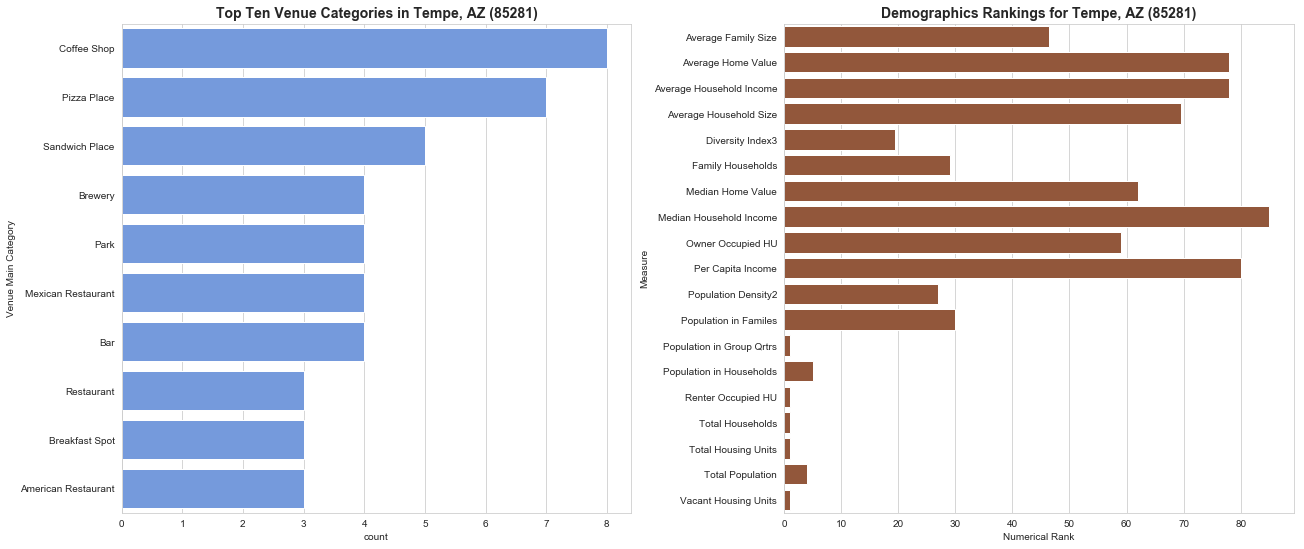

In [7]:
# Filter columns we are interested in for later use
filtered_columns = ['Venue', 'Venue Main Category', 'Venue Latitude', 'Venue Longitude']
tempe_venues = result_venues.loc[result_venues[result_venues.ZipCode == '85281'].index, filtered_columns]

# Get the counts of venues by category and choose the top 10 from the list. We
# have to sort these twice because of what I think is a bug in barh where you
# can't specify the order the bars appear in.
cats = tempe_venues.groupby(['Venue Main Category'], as_index=False).size().to_frame('count')
cats.sort_values(by=['count'], ascending=False, inplace=True)
cats.reset_index(inplace=True)
cats_top10 = cats[:10].sort_values(by=['count'], ascending=False)

# Get the numerical ranks for all the demographics features
demog = results.loc[:, "Average Family Size":"Vacant Housing Units"]
ranks = demog.rank(axis=0, ascending=False)
ranks['ZipCode'] = results['ZipCode']
td = ranks.loc[results['ZipCode'] == '85281', 
               "Average Family Size":"Vacant Housing Units"].reset_index(drop=True).transpose().reset_index()
td.columns = ['Measure','Numerical Rank']

# Draw the plots
index = np.arange(10)
fig, axs = plt.subplots(1,2,figsize=(21,9))
fig.subplots_adjust(wspace=.3)
sns.barplot(y="Venue Main Category", x="count", data=cats_top10, color='cornflowerblue', ax=axs[0])
axs[0].set_title('Top Ten Venue Categories in Tempe, AZ (85281)', fontdict={'size': 14, 'weight': 'bold'})
sns.barplot(x='Numerical Rank', y='Measure', data=td, color='sienna', ax=axs[1])
axs[1].set_title('Demographics Rankings for Tempe, AZ (85281)', fontdict={'size': 14, 'weight': 'bold'});


One other item of interest is the top venues visited after visiting my shop. The following code utilizes Foursquare's `NEXTVENUES` endpoint to find the top five venues most likely to be visited after my shop.

In [8]:
next_venues = csutil.get_nextvenues()
next_venues.head()

,Venue,Venue Main Category,Venue Latitude,Venue Longitude
0,Casey Moore's Oyster House,Seafood Restaurant,33.420793,-111.942643
1,Buffalo Exchange,Thrift / Vintage Store,33.421699,-111.943222
2,Otto Pizza and Pastry,Pizza Place,33.421443,-111.942493
3,Dutch Bros. Coffee,Coffee Shop,33.416966,-111.926024
4,Four Peaks Brewing Company,Brewery,33.419517,-111.915911


#### Demographics

As we have seen from displays of the dataset,the demographic data has a great deal of variety in terms of features. Specifically the data contain

* Monetary values for things like income and property values, which may be very different in some cases
* A Diversity Index, which is essentially a probability that two persons, chosen at random from the zip code, belong to different race or ethnic groups
* Quantitative values, such as the number of owner-occupied housing units and various population counts
* Measures such as population density which is the total population per square mile

Next I want to look at the descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, and to see if there are values that look like outliers. The following code produces boxplots of some of the dataset's features, and are separated into groups of 'like' features.

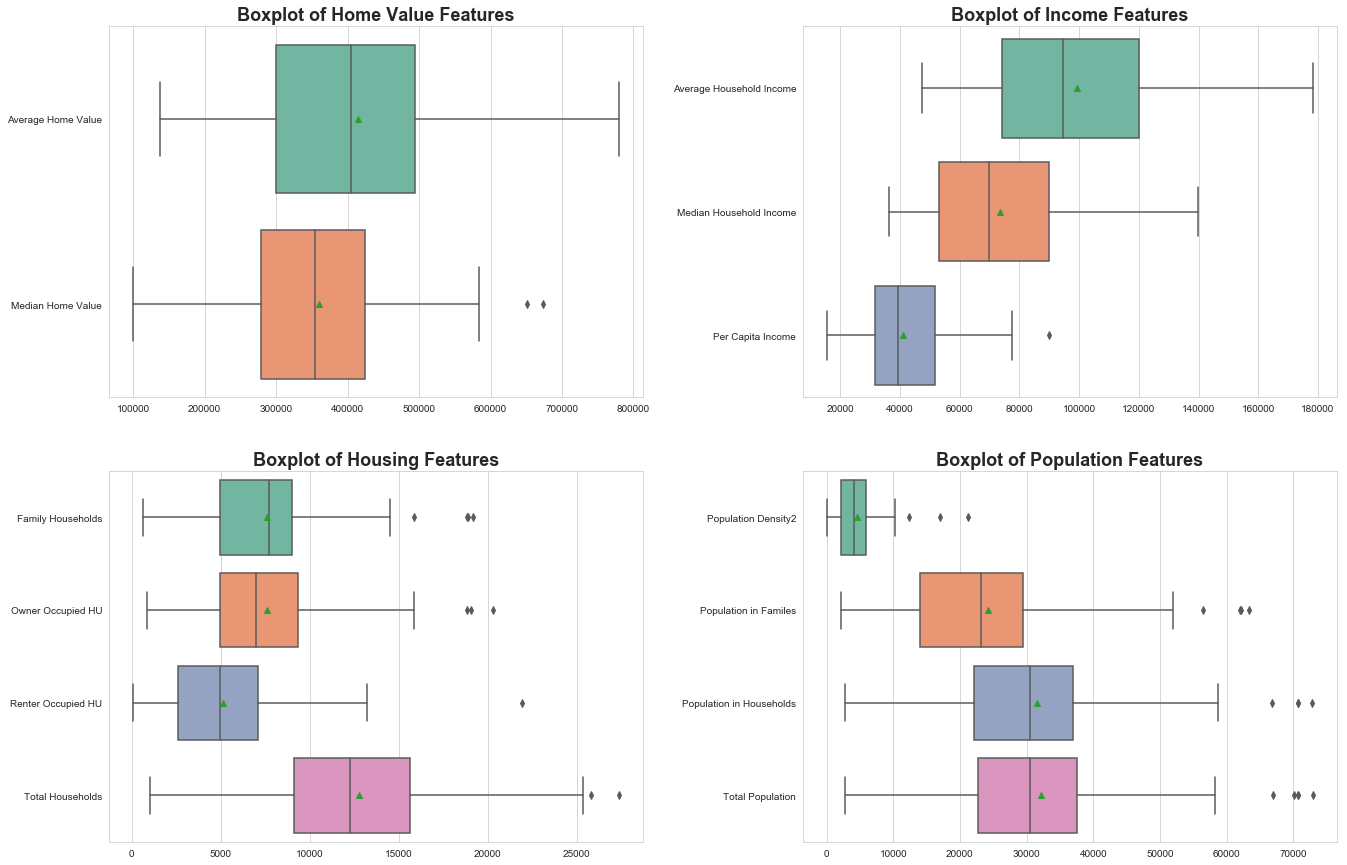

In [9]:
# Since there is so much variety in the data, I'm showing plots of related features
# so that the scales make sense
# Slice into separate dataframes
df_home = demog.loc[:, ['Average Home Value','Median Home Value']]
df_income = demog.loc[:, ['Average Household Income', 'Median Household Income', 'Per Capita Income']]
df_housing = demog.loc[:, ['Family Households', 'Owner Occupied HU', 'Renter Occupied HU', 'Total Households']]
df_population = demog.loc[:, ['Population Density2', 'Population in Familes', 'Population in Households','Total Population']]

# Create and display the plots
fig, axs = plt.subplots(2,2, figsize=(22,15))
fig.subplots_adjust(wspace=.3)
sns.boxplot(data=df_home, orient="h", palette="Set2", ax=axs[0,0], showmeans=True)
axs[0,0].set_title('Boxplot of Home Value Features', fontdict={'size': 18, 'weight': 'bold'})
sns.boxplot(data=df_income, orient="h", palette="Set2", ax=axs[0,1], showmeans=True)
axs[0,1].set_title('Boxplot of Income Features', fontdict={'size': 18, 'weight': 'bold'})
sns.boxplot(data=df_housing, orient="h", palette="Set2", ax=axs[1,0], showmeans=True)
axs[1,0].set_title('Boxplot of Housing Features', fontdict={'size': 18, 'weight': 'bold'})
sns.boxplot(data=df_population, orient="h", palette="Set2", ax=axs[1,1], showmeans=True)
axs[1,1].set_title('Boxplot of Population Features', fontdict={'size': 18, 'weight': 'bold'});

##### Observations on Demographics Features

The boxplots show some values for some of the features as outliers. As an example, Total population has some very notable and large outliers, one of which happens to be Tempe, the other of which is 80219. The latter has a population density, however, that isn't an outlier, which indicates that the population is perhaps a function of another variable, possibly the total land area of the zip code. Similarly, the outliers in population density are both very small counties in Denver and suggest that perhaps there are a higher number of multi-family housing units in those zip codes. Please note that I looked for data that had a breakdown of the types of housing units in each zip code, but could find no reliable source. I conclude from what I've seen and the research I've done that the features I'm using are likely affected by other features that I cannot reliably collect or determine.

I do not believe I can qualify any of the values in the dataset as true 'outliers'. In a sense, the values are what they are and are intrinsic measurements of a specific area. K-Means clustering is sensitive to outliers, so I need to choose a method of scaling the data that will appropriately represent the outliers. `Scikit-learn` includes a preprocessor named `RobustScaler` which removes the median and scales the data according to the quantile range and is therefore not influenced by a few number of very large marginal outliers, which I will be using to scale the data prior to clustering.

Next, I examine the correlation matrix of the entire dataset to see if we can find any patterns that might help with further dimensionality reduction.

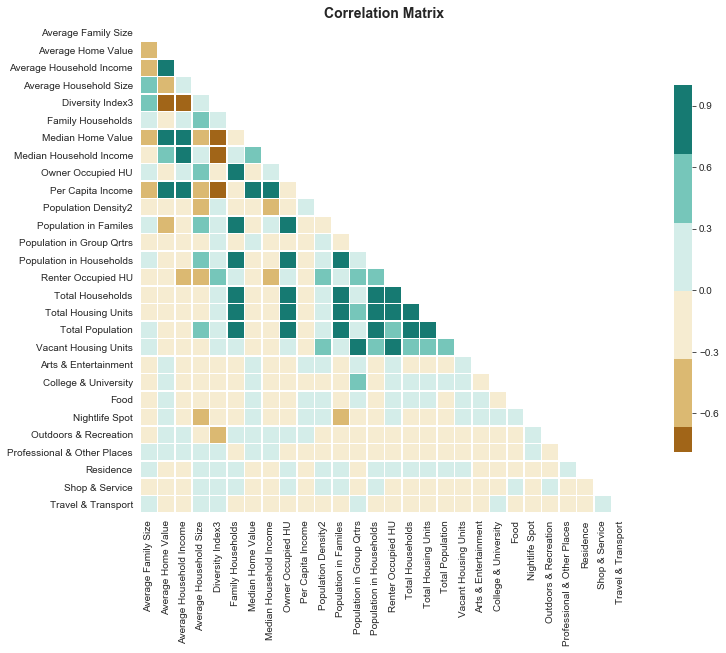

In [10]:
# For most of the rest of the exploration and clustering we need this data without
# zip code, latitude or longitude
df_clustering = final_merged.drop(['ZipCode','Latitude','Longitude'], axis=1)
corr = df_clustering.corr()

# Create a correlation matrix on our demograpics data, but without coordinates
corr = df_clustering.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("BrBG")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});
ax.set_title('Correlation Matrix', fontdict={'size': 14, 'weight': 'bold'});

##### Observations on Correlation Matrix

From the matrix, there are some correlations that make sense. For home values, the average and median values are strongly positively correlated, as are median/average home values and average household income. Households and housing units are obviously strongly correlated because, while a housing unit is a house, an apartment, a mobile home, a group of rooms, or a single room occupied (or if vacant, intended for occupancy) as separate living quarters, a household includes all the people who occupy a housing unit. So, these two things would vary depending on just sheer numbers of housing units.

A couple of interesting correlations are also revealed. Average home value is strongly negatively correlated to both diversity index and average household size, which means larger households occupy lower-valued homes and that neighborhoods containing a high-degree of a single ethnicity (regardless of the ethnicity) contain lower-valued homes. Similarly, per capita income is also strongly negatively correlated with diversity index, meaning that more diverse neighborhoods have lower incomes than less diverse ones. Lastly, the venue category Nightlife Spot was fairly strongly negatively correlated with Population in Families,.

### Dimensionality Reduction

Based on this matrix, I am going to be removing several features, based on correlation and an understanding of the underlying data. Total population is a good candidate for removal, since we have a similar and more rich feature, population density that is more descriptive because it takes into account the size of a zip code, which is data I cannot obtain. Since I have made a modification to Median Home Value and Average Home Value is strongly correlated to that, I'm removing Average Home Value. I'm also removing the features related to housing units, because we have a similar measure, Total Households, to which it is also strongly correlated. I'm also removing one feature from the venues features, 'Residence' because I don't consider Foursquare to be a good source of residence information.

Below, we remove those features, and show the shape of the final dataset.

In [11]:
# Remove the noted features
df_clustering.drop(['Average Home Value','Total Population','Total Housing Units', 'Vacant Housing Units', 'Residence'], axis=1, inplace=True)
print("The resulting DataFrame contains {} observations with {} features".format(df_clustering.shape[0], df_clustering.shape[1]))

The resulting DataFrame contains 85 observations with 23 features


### Identifying Candidate Zip Codes

Here we will use our reduced-dimension dataset to cluster all the data to find any Denver metro zip codes that are in the same cluster as Tempe. First, as discussed, we first scale the data with RobustScaler.

In [12]:
from sklearn.preprocessing import RobustScaler

# Do not rescale zip code, latitude or longitude
features = [c for c in df_clustering if c not in ['ZipCode','Latitude', 'Longitude']]
X = df_clustering.loc[:, features].values
rescaled = RobustScaler().fit_transform(X)

Next, we look for the optimum value for k for clustering.

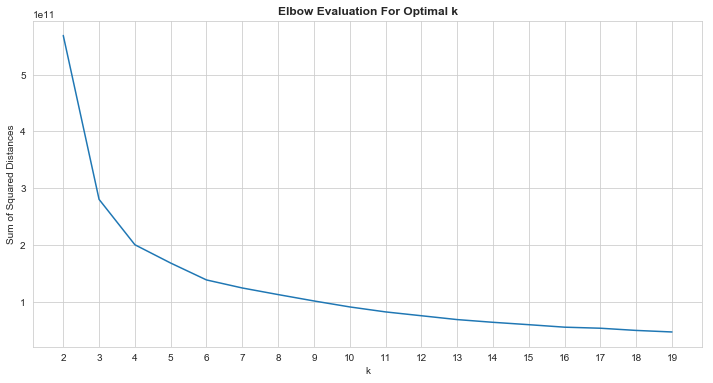

In [13]:
from sklearn.cluster import KMeans

# Sum of squared distances, for the elbow method
ssd = []

# Range of values for k
K = range(2,20)

for k in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=13031)
    kmeans = kmeans.fit(X)
    ssd.append(kmeans.inertia_)

# Generate a basic plot to help us decide on a value of k
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=K, y=ssd)
ax.set_title('Elbow Evaluation For Optimal k', fontdict={'size': 12, 'weight': 'bold'})
ax.set(xlabel='k', ylabel='Sum of Squared Distances', xticks=np.arange(2,20));

Based on the elbow plot, there is a distinct elbow around 6 or 7 and another at about 16. For this analysis, I'm choosing k to be 7. Below we use that value to do the actual clustering, and assign the cluster labels to our original dataset.

In [14]:
# Run k-means clustering with the optimized values
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=13031)
kmeans = kmeans.fit(X)

# Add clustering labels directly to the final merged set because nothing changed the index
try:
    final_merged.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
final_merged.insert(0, 'Cluster Labels', kmeans.labels_)

# We also need the cluster labels added to the one-hot-encoding-derived top 10 list. That
# was indexed differently so we use merge to add those
fm_labels = final_merged.loc[:, ['ZipCode','Cluster Labels']].copy()
clustered_top10 = pd.merge(fm_labels, result_venues_sorted, left_on='ZipCode', right_on='ZipCode', how='inner', validate='1:1')
clustered_top10 = clustered_top10[['Cluster Labels','ZipCode'] + [c for c in clustered_top10 if c not in ['Cluster Labels','ZipCode']]]

# Show the main data
final_merged.tail()

,Cluster Labels,ZipCode,Latitude,Longitude,Average Family Size,Average Home Value,Average Household Income,Average Household Size,Diversity Index3,Family Households,...,Vacant Housing Units,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
80,4,80302,40.038629,-105.371668,3,779382,87478,2.17,28,3994,...,699,2.0,0,22.084507,5.400000,4.200000,0,0,7.142857,1.000000
81,1,80303,40.000538,-105.207780,3,630501,88061,2.03,37,4623,...,520,3.0,0,14.440000,2.117647,7.714286,2,0,15.206897,2.000000
82,4,80304,40.045474,-105.283851,3,714307,128222,2.34,38,6427,...,515,5.0,0,21.591837,2.571429,5.062500,0,0,11.636364,1.000000
83,1,80305,39.979999,-105.248737,3,608794,122365,2.42,27,3791,...,139,3.0,4,12.000000,4.000000,3.700508,0,0,13.444444,2.666667
84,6,85281,33.436665,-111.940325,3,224072,57902,2.15,74,8653,...,4092,6.0,2,17.808696,2.941176,4.545455,0,0,7.000000,1.000000


Lastly, we visualize the clustering results across the Denver metro area.

In [15]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create map
map_clusters = folium.Map(location=denxy, zoom_start=9)

# Set color scheme for the clusters. We are using the tab10 qualitative colormap
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
tab10 = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for zipcode, lat, lon, cluster in zip(final_merged['ZipCode'], final_merged['Latitude'], final_merged['Longitude'], final_merged['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(zipcode, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=tab10[cluster],
        fill=True,
        fill_color=tab10[cluster],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Results

We can see from the above that Tempe was placed into Cluster 6. With this in mind, we can now start to examine the cluster and the data we have to see if we can find from the candidates any suitable locations to pursue for my expansion. Lets briefly examine Cluster 6 by looking at the top 10 venues for each zip code using our one-hot encoded data.

In [16]:
clustered_top10.loc[clustered_top10['Cluster Labels'] == 6, clustered_top10.columns[[1] + list(range(2, clustered_top10.shape[1]))]]

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,80204,Brewery,Mexican Restaurant,Coffee Shop,Theme Park,Park,Theater,Sports Bar,Convenience Store,Comedy Club,Museum
19,80236,Mexican Restaurant,Coffee Shop,Convenience Store,Sandwich Place,Pizza Place,Gym / Fitness Center,American Restaurant,Grocery Store,Brewery,Park
24,80249,Coffee Shop,Airport Lounge,Steakhouse,Burger Joint,Pizza Place,Cosmetics Shop,Dessert Shop,Bagel Shop,Juice Bar,Ice Cream Shop
35,80003,Coffee Shop,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Bakery,Sushi Restaurant,Brewery,Sandwich Place,Chinese Restaurant,Thrift / Vintage Store
44,80214,Coffee Shop,American Restaurant,Mexican Restaurant,Spa,Sandwich Place,Fast Food Restaurant,Thai Restaurant,Brewery,Breakfast Spot,Movie Theater
49,80232,Mexican Restaurant,Coffee Shop,Spa,Sandwich Place,Italian Restaurant,Cosmetics Shop,Grocery Store,Ice Cream Shop,Vietnamese Restaurant,American Restaurant
56,80013,Convenience Store,Park,Pizza Place,Mexican Restaurant,Coffee Shop,Brewery,Sandwich Place,Liquor Store,Fast Food Restaurant,American Restaurant
57,80014,Mexican Restaurant,Coffee Shop,Pizza Place,American Restaurant,Breakfast Spot,Japanese Restaurant,Sushi Restaurant,Park,Bar,Pharmacy
62,80110,Mexican Restaurant,Coffee Shop,Grocery Store,Park,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Breakfast Spot,Thai Restaurant,Liquor Store
84,85281,Coffee Shop,Pizza Place,Sandwich Place,Bar,Park,Brewery,Mexican Restaurant,American Restaurant,Restaurant,Breakfast Spot


This shows that for all but one zip code in the cluster, that a Coffee Shop is in the top 3 venues recommended, and for that one, a Coffee Shop is still in the top 5. So, people are going to these zip codes for coffee, which is at least promising. Lets take a look at the demographics to see how those line up.

In [17]:
candidates = final_merged.loc[final_merged['Cluster Labels'] == 6, :]
candidates

,Cluster Labels,ZipCode,Latitude,Longitude,Average Family Size,Average Home Value,Average Household Income,Average Household Size,Diversity Index3,Family Households,...,Vacant Housing Units,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
2,6,80204,39.738037,-105.026520,4,330070,60754,2.51,81,7368,...,1048,7.474576,0,9.573427,2.419355,2.666667,1,0,9.800000,3.000000
19,6,80236,39.647845,-105.041130,3,299889,71617,2.67,77,3849,...,154,3.000000,0,14.857143,3.571429,7.347826,0,0,9.920635,2.000000
24,6,80249,39.878664,-104.682105,4,295363,80689,3.33,86,7740,...,81,0.000000,0,12.235955,3.000000,0.000000,0,0,4.500000,2.666667
35,6,80003,39.818249,-105.067432,3,283636,78343,2.60,56,8749,...,247,3.000000,0,17.893617,4.764706,7.117647,1,0,12.461538,0.000000
44,6,80214,39.737670,-105.067432,3,298929,57206,2.24,73,5704,...,525,1.000000,1,13.630037,2.272727,4.500000,0,0,12.521739,1.000000
49,6,80232,39.688427,-105.096661,3,305613,80767,2.46,62,5729,...,206,3.000000,0,18.150838,1.800000,6.250000,0,0,13.000000,1.000000
56,6,80013,39.656342,-104.763762,3,282151,87088,2.83,69,18820,...,818,2.000000,0,11.226804,1.470588,2.380952,0,0,10.714286,1.800000
57,6,80014,39.663161,-104.827951,3,263587,74218,2.12,65,9817,...,1211,0.000000,0,20.787709,5.400000,7.363636,0,0,16.666667,1.000000
62,6,80110,39.648790,-105.014832,3,263791,58897,2.37,67,5834,...,674,4.000000,0,12.255319,5.444444,6.125000,0,0,14.695652,1.000000
84,6,85281,33.436665,-111.940325,3,224072,57902,2.15,74,8653,...,4092,6.000000,2,17.808696,2.941176,4.545455,0,0,7.000000,1.000000


#### A Look at Existing Coffee Shops

Lastly, I want to dig a little into the existing coffee shops in the candidate zip codes, see what types they are (meaning are they franchise or independent) and where they are located. I'm also only concerned with actual coffee shops, so because the Foursquare 'coffee' section returns things like tea rooms, cafés, and convenience stores (all of whom serve coffee), those venues aren't really like my shop. I also wanted to distinguish between franchise and independent coffee shops. The code below retrieves the top 100 recommended venues in the 'coffee' category, removes the venues that are not coffee shops, and determines whether each is a franchise or not using a list of coffee franchises obtained from Wikipedia and then shows a visualization. 

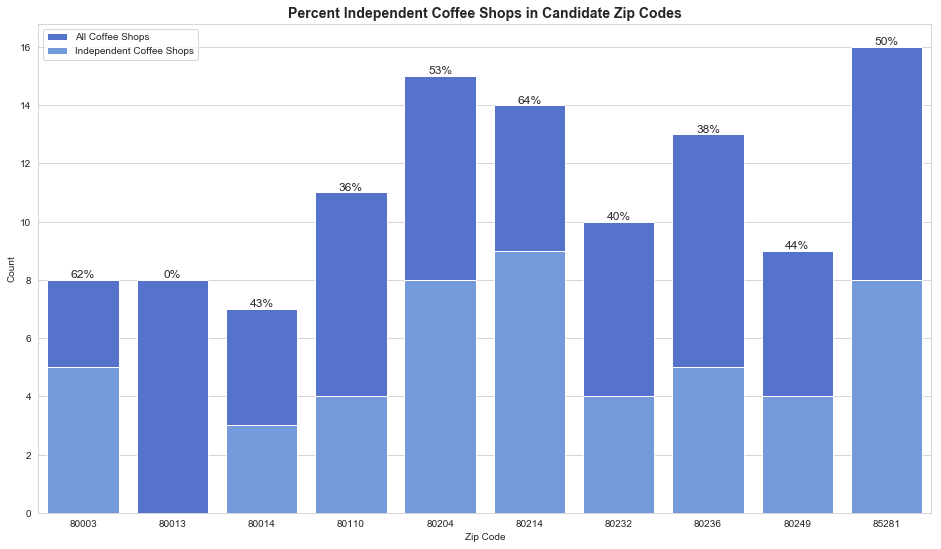

In [18]:
# Get the shops from the candidates using Foursquare EXPLORE with a section = 'coffee'
candidate_shops = csutil.get_coffee_shops(rownames=candidates['ZipCode'],
                                       latitudes=candidates['Latitude'],
                                       longitudes=candidates['Longitude'])

# Create and sort a pivot table showing the counts with the margin totals calculated
grouped_shops = candidate_shops.groupby(['ZipCode','IsFranchise'], as_index=False)['Venue'].count()
pivoted_shops = pd.pivot_table(grouped_shops, index='ZipCode', columns='IsFranchise', values='Venue', aggfunc='sum', margins=True, fill_value=0)
pivoted_shops.reset_index(inplace=True)
pivoted_shops = pivoted_shops[:-1]
pivoted_shops[['PctInd']] = pivoted_shops.apply(lambda row: pd.Series(row['False'] / row['All']), axis=1)

# Draw the plot
fig, ax = plt.subplots(figsize=(16,9))
bp_all = sns.barplot(x='ZipCode', y='All', data=pivoted_shops, color='royalblue', label='All Coffee Shops')
sns.barplot(x='ZipCode', y='False', data=pivoted_shops, color='cornflowerblue', label='Independent Coffee Shops')
ax.set_title("Percent Independent Coffee Shops in Candidate Zip Codes", fontdict={'size': 14, 'weight': 'bold'})
ax.set(xlabel='Zip Code', ylabel='Count')
ax.legend(loc='best');

# Label the bars with percent independent
for idx, rect in enumerate(ax.patches[:10]):
    ax.text(rect.get_x() + rect.get_width()/2, 
            rect.get_height() + .006, 
            str(int((pivoted_shops.loc[idx, 'PctInd'] * 100).round(0))) + '%',
            ha='center', va='bottom', fontdict={'fontsize': 12})

## Discussion

The results of the clustering revealed nine other zip codes that were similar in nature to Tempe, and while each of these zip codes might warrant further investigation I'd like to choose a small set of them to focus on, using our stated criteria.

### Deeper Look at Candidates

#### Exclusions

Of the nine other zip codes in the cluster, the following are being excluded from further consideration: 80003, 80013, 80014, 80214, and 80249. Zip code 80013 has no independent coffee shops, but the most commonly visited venue there is a convenience store. Zip code 80249 is near Denver International Airport. Zip codes 80003, 80214, and 80204 already have more than 50% independent coffee shops. Further, based on other investigation, many contain no 'anchor' venues, and despite some of their proximity to parks simply do not meet the stated criteria.

#### Final Candidate Zip Codes

The following zip codes show promise as possible expansion zip codes. Further analysis would be needed to determine overall feasibility which should include appropriate and and available real estate (including proximity to any existing coffee shops), further demographic analysis to include breakdowns of age groups and ethnic diversity, crime rates and other relevant criteria. 

##### 80204

This area is just to the west of downtown Denver with close proximity to popular venues such as the Colorado Convention Center, Denver Center for the Performing Arts, and the trendy LoDo neighborhood. It also includes both Mile High stadium and the Pepsi Center, which host Denver's professional sports teams and A-List concerts. It encompasses both the Auraria Campus and the West Colfax and Lincoln Park neighborhoods. It is also host to the Santa Fe Arts District and has good proximity to Sloan's Lake Park. One shortcoming is that it already contains a relatively high number of independent coffee shops, approximately 57%. Coffee shops are also the third most common venue visited in this zip code.

##### 80236

This is largely a residential neighborhood that contains Mullen High School, a prestigious private Catholic preparatory school. It is comprised the Harvey Park South neighborhood, which contains homes built in the 1950s, like Tempe. [Charms and challenges in Denver’s best kept “mid-mod” secret](https://www.denverpost.com/2012/09/28/charms-and-challenges-in-denvers-best-kept-mid-mod-secret/) describes some of these homes by saying, "That these are special homes was far from secret in 1955. "*This design was so well-thought-out that several of the buyers were young architects who had been trained after World War II on the G.I. Bill*" It is also about a ten minute drive to the University of Denver and has close proximity to Marsten Lake, which is a popular birding location. It has the fourth lowest percentages of independent coffee shops, at about 43%. Coffee shops are the second most common venue visited in this zip code.

##### 80110

This area is a mix of commercial and residential almost directly south of downtown Denver. It has very close proximity to Cherry Hills Village, which is a very affluent neighborhood with a very prestigious golf club. It also has good proximity to Swedish Medical Center and Craig Hospital in Englewood as well as to the Gothic Theater, which is an up-close live music venue converted from an art deco movie. It also has close proximity to Arapahoe Community College in Littleton and the University of Denver. It has the second lowest percentages of independent coffee shops, at about 36%. Coffee shops are the second most common venue visited in this zip code.

## Conclusion

In this study I sought to identify some target zip codes in the Denver metro area that could potentially be a site for the expansion of my coffee shop in Tempe, AZ. I combined demographic data for selected zip codes in the Denver metro area with venue and category data from Foursquare and used the data as the basis for clustering to identify zip codes that are most similar to 85281. Based on the clustering nine candidate zip codes were found, of which three were identified as the most suitable for further investigation and planning. Before considering any expansion those three would need further, detailed analysis to identify a suitable location. 

## References

The following sources were used in the creation of this study.

* IBM Applied Data Science Course Materials and Labs
* [**My Python Utility Module**](https://github.com/jrfoster/Coursera_Capstone/blob/master/capstoneutils.py)
* [Sperling's Best Places](https://www.bestplaces.net/cost-of-living/tempe-az/denver-co/50000)
* [Foursquare API Documentation](https://developer.foursquare.com/docs/api/endpoints)
* [scikit-learn Documentation](https://scikit-learn.org/stable/index.html)
* [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)
* [Anytree Documentation](https://anytree.readthedocs.io/en/latest/)
* [Simpsons Diversity Index](http://www.countrysideinfo.co.uk/simpsons.htm)
* [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start)
* [Top Neighborhoods for Young Professionals](http://urbanphenix.com/neighborhoods-in-denver-for-young-professionals/)
* [Charms and challenges in Denver’s best kept “mid-mod” secret](https://www.denverpost.com/2012/09/28/charms-and-challenges-in-denvers-best-kept-mid-mod-secret/)
* [List of Coffeehouse Chains](https://en.wikipedia.org/wiki/List_of_coffeehouse_chains)
